<a href="https://colab.research.google.com/github/alexlyk93/alexlyk93.github.io/blob/master/Scraping_TVs_info_from_ecommerce_site.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OBTAIN DATA**

In [1]:
#import scraping library
from bs4 import BeautifulSoup
import requests
import re

In [2]:
links = []

#looping all pages
for i in range(5):
  url = "https://www.senheng.com.my/home-entertainment/tv.html?p={}".format(i)
  r = requests.get(url)
  soup = BeautifulSoup(r.content,'html')
  results = soup.find_all('div',{'class':'product-item-info'})
  for result in results:
    links.append(result.a['href'])

In [3]:
all_list = []

#looping all link and extract product info
for link in links:
  content = {}
  page_respone = requests.get(link)
  page_content = BeautifulSoup(page_respone.content,'html')
  content['Title'] = page_content.select('h1')[0].text.strip()
  content['Stock'] = page_content.find_all('div',{'title':'Availability'})[0].text.strip()
  content['Link'] = link

  try:
    content['Warranty'] = page_content.find_all('div',{'itemprop':'warranty'})[0].text.strip()
  except IndexError:
    content['Warranty'] = 'Without Warranty'

  try:
    content['Display_format'] = page_content.find_all('li',{'class':'item 4'})[0].text.strip()
  except:
    content['Display_format'] = ''

  try:
    content['Current_price (RM)'] = page_content.find_all('span',{'class':'price'})[0].text.strip()
  except:
    content['Current_price (RM)'] = ''

  try:
    content['Original_price (RM)'] = page_content.find_all('span',{'class':'old-price'})[0].text.strip()
  except:
    content['Original_price (RM)'] = ''

  try:
    content['Rating'] = page_content.find_all('a',{'class':'nobr'})[0].text.split()[0]
  except:
    content['Rating'] = 'No review'

  try:
    content['Inch'] = page_content.find_all('td',{'data-th':'TV Screen Size (inch)'})[0].text.strip()
  except:
    content['Inch'] = ''

  try:
    content['Qty_sold'] = int(page_content.find_all('span',{'itemprop':'reviewCount'})[0].text.strip())
  except:
    content['Qty_sold'] = 0

  all_list.append(content)


# **CLEAN DATA**

In [4]:
#import pandas library
import pandas as pd

#convert dictionery into dataframe
df = pd.DataFrame(all_list)

In [5]:
#extract brands from title
df['Brand'] = df['Title'].str.split().str[0]

#split to two dataframe, with value and without value
_a = df[df['Inch'] == '']
_b = df[df['Inch'] != '']

In [6]:
_a['Inch'] = df['Title'].str.split().str[1]

#replace the size
_a.loc[_a['Title'] == 'Samsung Q60T QLED 4K UHD HDR Smart TV 2020' ,'Inch'] = '65'
_a.loc[_a['Title'] == 'Sharp 8K Resolution TV SHP-8TC80AX1X' ,'Inch'] = '80'
_a.loc[_a['Title'] == 'Samsung Q60T QLED 4K UHD HDR Smart TV 2020-75 Inches' ,'Inch'] = '75'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [7]:
#replace size into category
_a['Inch'] = _a['Inch'].str[:1]
mappings = {'3':'39 Inches & Below',
            '4':'40 - 49 Inches',
            '5':'50 - 59 Inches',
            '6':'60 - 69 Inches',
            '7':'70 - 79 Inches',
            '8':'80 Inches and above'}
_a['Inch'] = _a['Inch'].replace(mappings)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [8]:
#drop computer's monitor
computer_index = _a[_a['Inch'] == '2'].index
_a = _a.drop(computer_index)

In [9]:
#join dataframe
final = pd.concat([_a,_b])

In [10]:
#check number of duplicated rows
final.duplicated().sum()

40

In [11]:
#drop duplicated rows
final.drop_duplicates(inplace=True)

In [12]:
#remove unwanted symbol
final['Current_price (RM)'] = final['Current_price (RM)'].str[2:-3]
final['Original_price (RM)'] = final['Original_price (RM)'].str[2:-3]

final['Current_price (RM)'] = final['Current_price (RM)'].str.replace('[^\w\s]','')
final['Original_price (RM)'] = final['Original_price (RM)'].str.replace('[^\w\s]','')

#convert to interger
final[['Current_price (RM)','Original_price (RM)']] = final[['Current_price (RM)','Original_price (RM)']].astype('int')

In [13]:
#replace missing data
final.loc[(final['Brand']=='Sharp') & (final['Display_format'] == ''),'Display_format'] = 'UHD TVs'
final.loc[(final['Brand']=='LG') & (final['Display_format'] == ''),'Display_format'] = 'NanoCell TVs'
final.loc[(final['Brand']=='Sony') & (final['Display_format'] == ''),'Display_format'] = 'UHD TVs'

In [14]:
#Get the revenue from qty sold times with price
final['Revenue (RM)'] = final['Current_price (RM)'] * final['Qty_sold']

In [15]:
#random view the dataframe
final.sample(5)

,Title,Stock,Link,Warranty,Display_format,Current_price (RM),Original_price (RM),Rating,Inch,Qty_sold,Brand,Revenue (RM)
118,Sony 32-inch LED TV SNY-KDL32R300E,In stock,https://www.senheng.com.my/sony-32-inch-led-tv...,2-Years Warranty,LED TVs,989,1036,5,39 Inches & Below,0,Sony,0
119,Sharp 45-Inch Full HD Basic LED TV Model 2TC45...,In stock,https://www.senheng.com.my/sharp-45-inch-full-...,2-Years Warranty,LED TVs,1199,1699,4.5,40 - 49 Inches,2,Sharp,2398
137,Philips 55 inch 4K UHD LED Smart TV 55PUT6654/68,Out of stock,https://www.senheng.com.my/philips-55-inch-4k-...,2-Years Warranty,UHD TVs,2099,2599,No review,50 - 59 Inches,0,Philips,0
133,Panasonic 40-Inch G300 LED TV TH-40G300K,Out of stock,https://www.senheng.com.my/panasonic-40-inch-g...,2-Years Warranty,LED TVs,888,1349,No review,40 - 49 Inches,0,Panasonic,0
149,LG NANO79 55 Inch 4K NanoCell TV with AI ThinQ...,Out of stock,https://www.senheng.com.my/lg-nano79-55-inch-4...,2-Years Warranty,NanoCell TVs,3888,4099,No review,50 - 59 Inches,0,LG,0


In [16]:
#check the nnumber of rows, and data type
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 8 to 154
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                114 non-null    object
 1   Stock                114 non-null    object
 2   Link                 114 non-null    object
 3   Warranty             114 non-null    object
 4   Display_format       114 non-null    object
 5   Current_price (RM)   114 non-null    int64 
 6   Original_price (RM)  114 non-null    int64 
 7   Rating               114 non-null    object
 8   Inch                 114 non-null    object
 9   Qty_sold             114 non-null    int64 
 10  Brand                114 non-null    object
 11  Revenue (RM)         114 non-null    int64 
dtypes: int64(4), object(8)
memory usage: 11.6+ KB


In [17]:
#save to csv file / download csv file
final.to_csv("tv_info_data.csv")

#download file if needed
from google.colab import files
files.download("tv_info_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **EXPLORE DATA**

In [18]:
%matplotlib inline 

#import visualization library
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 

sns.set()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '# of TV model')

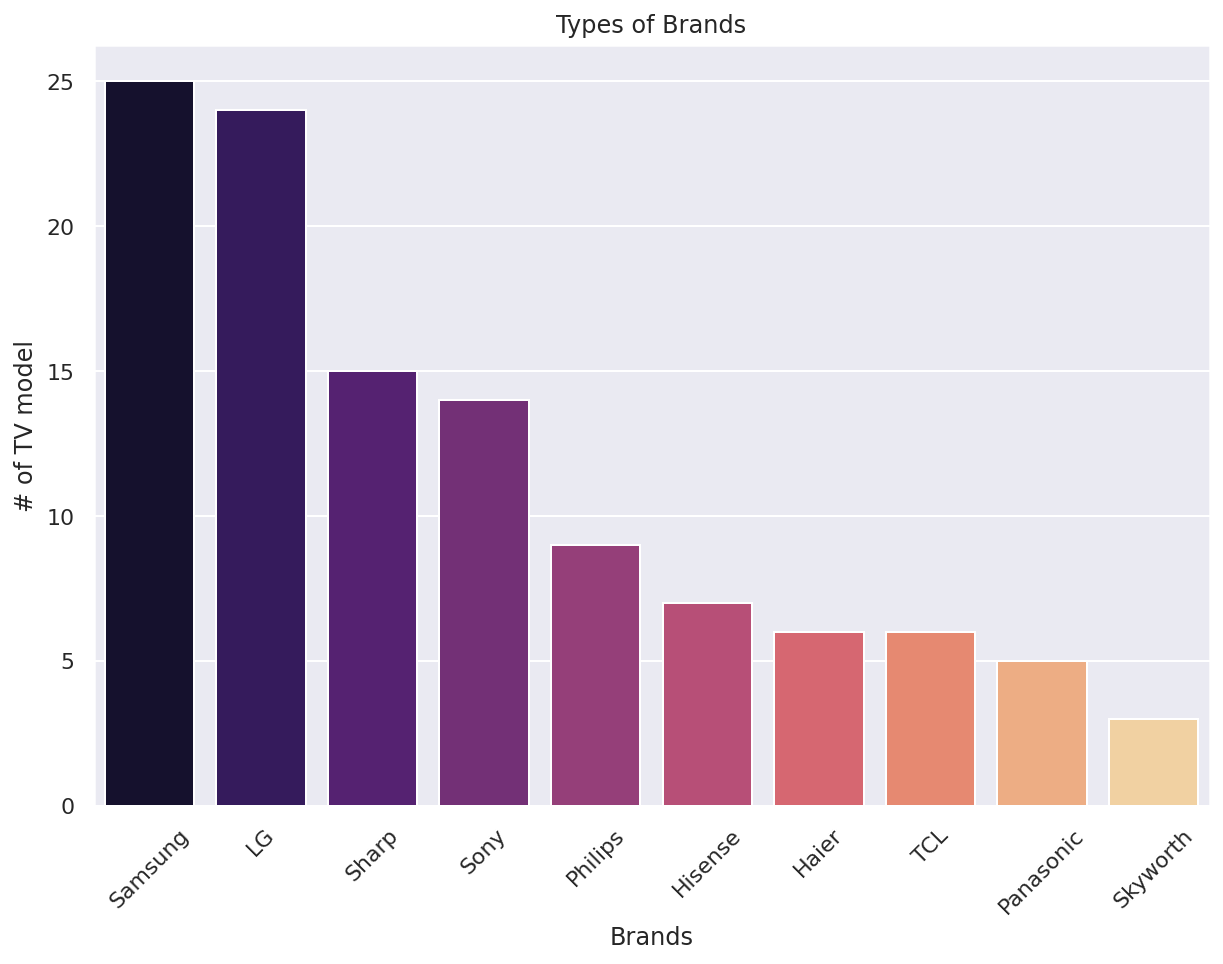

In [19]:
plt.figure(figsize=(10,7))
ax = sns.countplot(final['Brand'], order =final['Brand'].value_counts().index,palette = 'magma')
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=45)
plt.title('Types of Brands')
plt.xlabel('Brands')
plt.ylabel('# of TV model')

---
There are 10 brands of TVs carried by Senheng ecommerce shop. LG and Samsung are the popular brands, follow by Sony and Sharp.

---


Brand
LG           59
Samsung      42
Sony          2
Sharp         2
Philips       1
Haier         1
TCL           0
Skyworth      0
Panasonic     0
Hisense       0
Name: Qty_sold, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

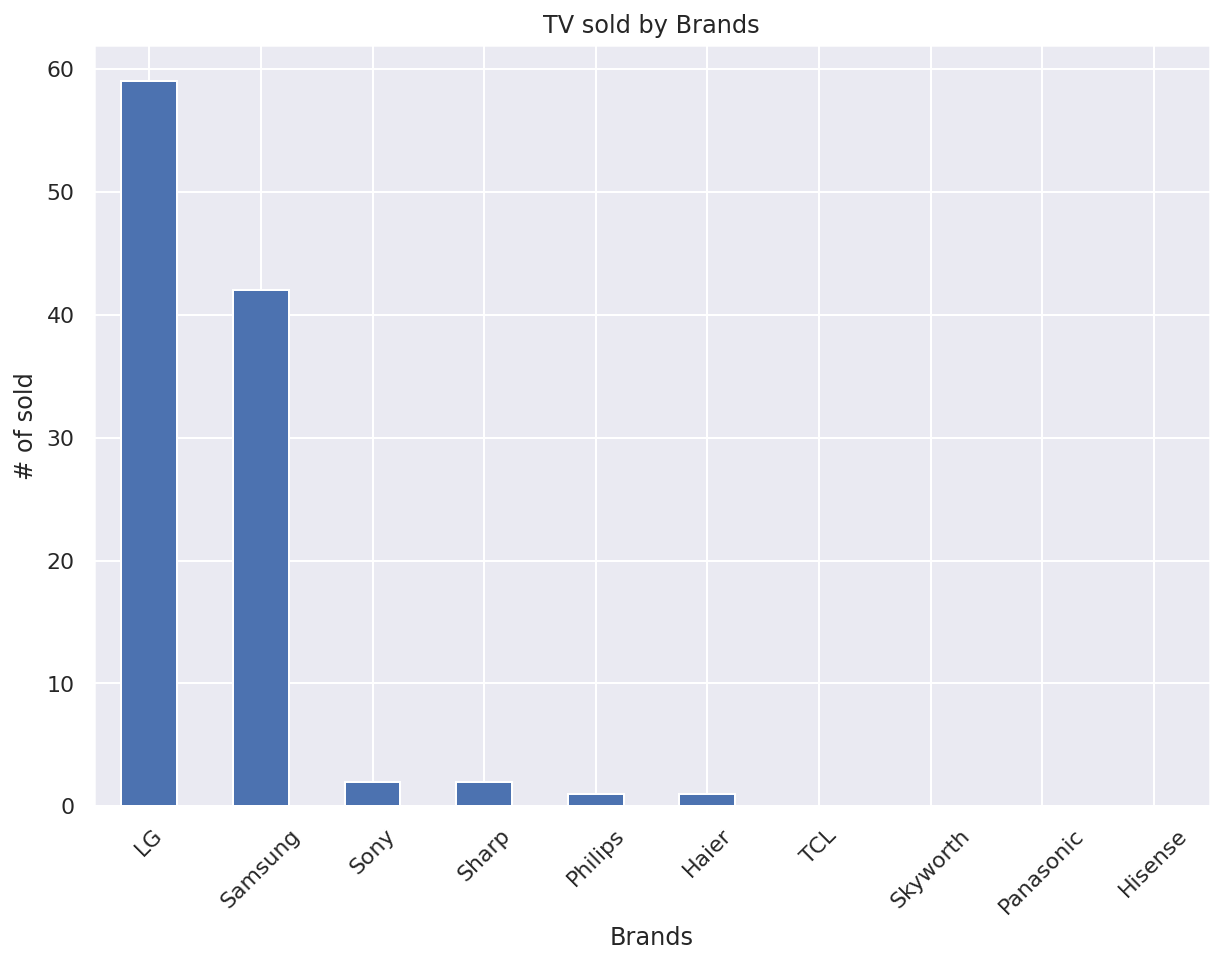

In [20]:
plt.figure(figsize=(10,7))
brands = final.groupby('Brand')['Qty_sold'].sum().sort_values(ascending=False).plot(kind='bar')
print(final.groupby('Brand')['Qty_sold'].sum().sort_values(ascending=False))
plt.title('TV sold by Brands')
plt.xlabel('Brands')
plt.ylabel('# of sold')
plt.xticks(rotation=45)

---
As refer to graph above, customer are more favorable to LG and Samsung brands. There are 57 units of LG and 35 units of Samsung TVs being sold out. There are no selling of Brands TCL, Skyworth, Philips, Panasonic and Hisense.

---

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '# of TV model')

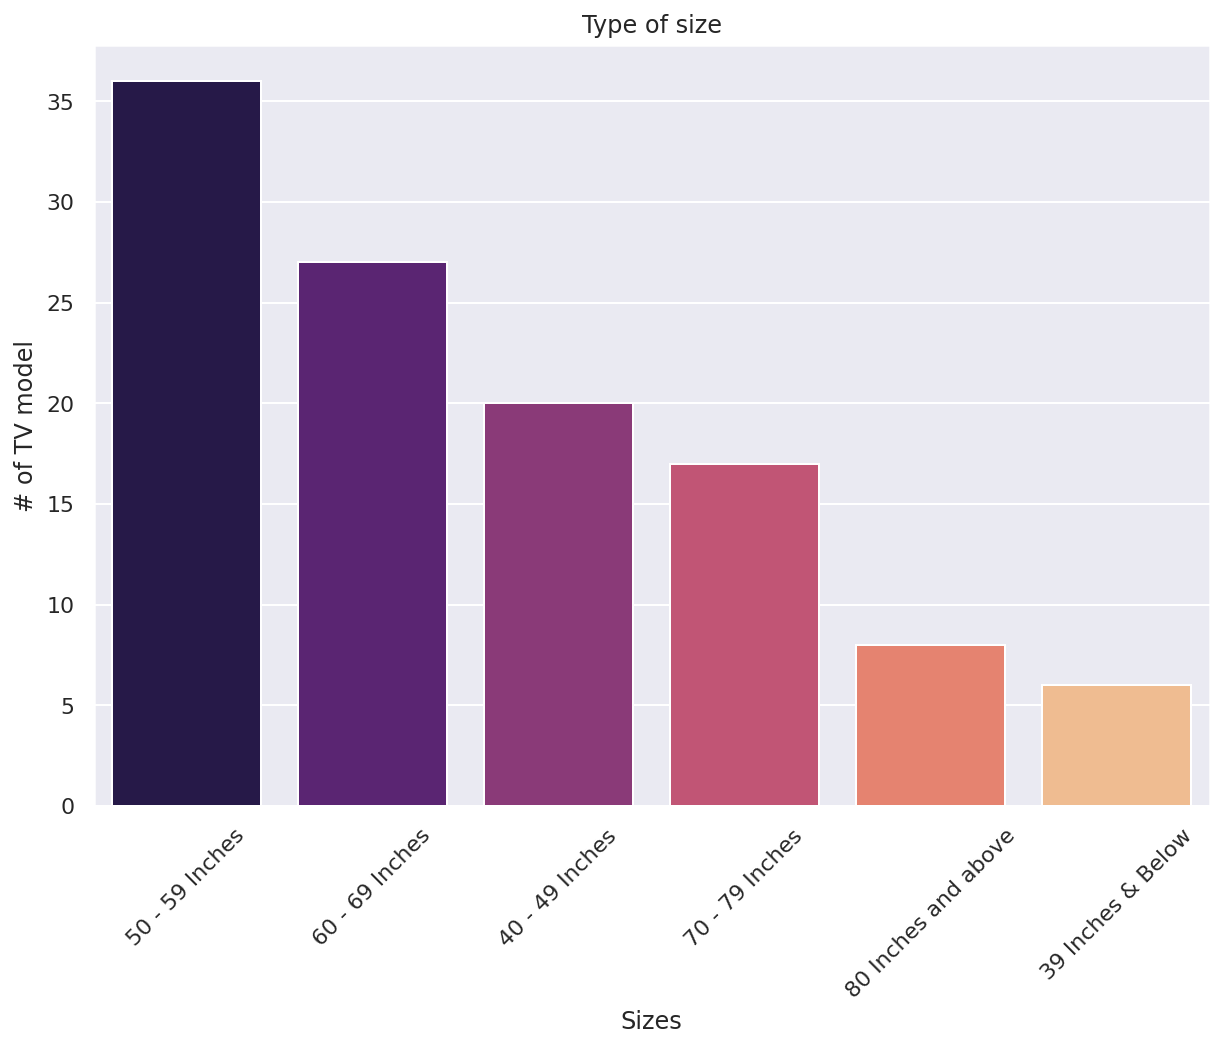

In [21]:
plt.figure(figsize=(10,7))
ax = sns.countplot(final['Inch'], order =final['Inch'].value_counts().index,palette = 'magma')
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=45)
plt.title('Type of size')
plt.xlabel('Sizes')
plt.ylabel('# of TV model')

---
Size of TVs carried by this ecommerce shop is vary. There are less quantity for the TVs size which are too small and too big.

---

Inch
50 - 59 Inches         55
60 - 69 Inches         27
40 - 49 Inches         20
70 - 79 Inches          3
80 Inches and above     2
39 Inches & Below       0
Name: Qty_sold, dtype: int64


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

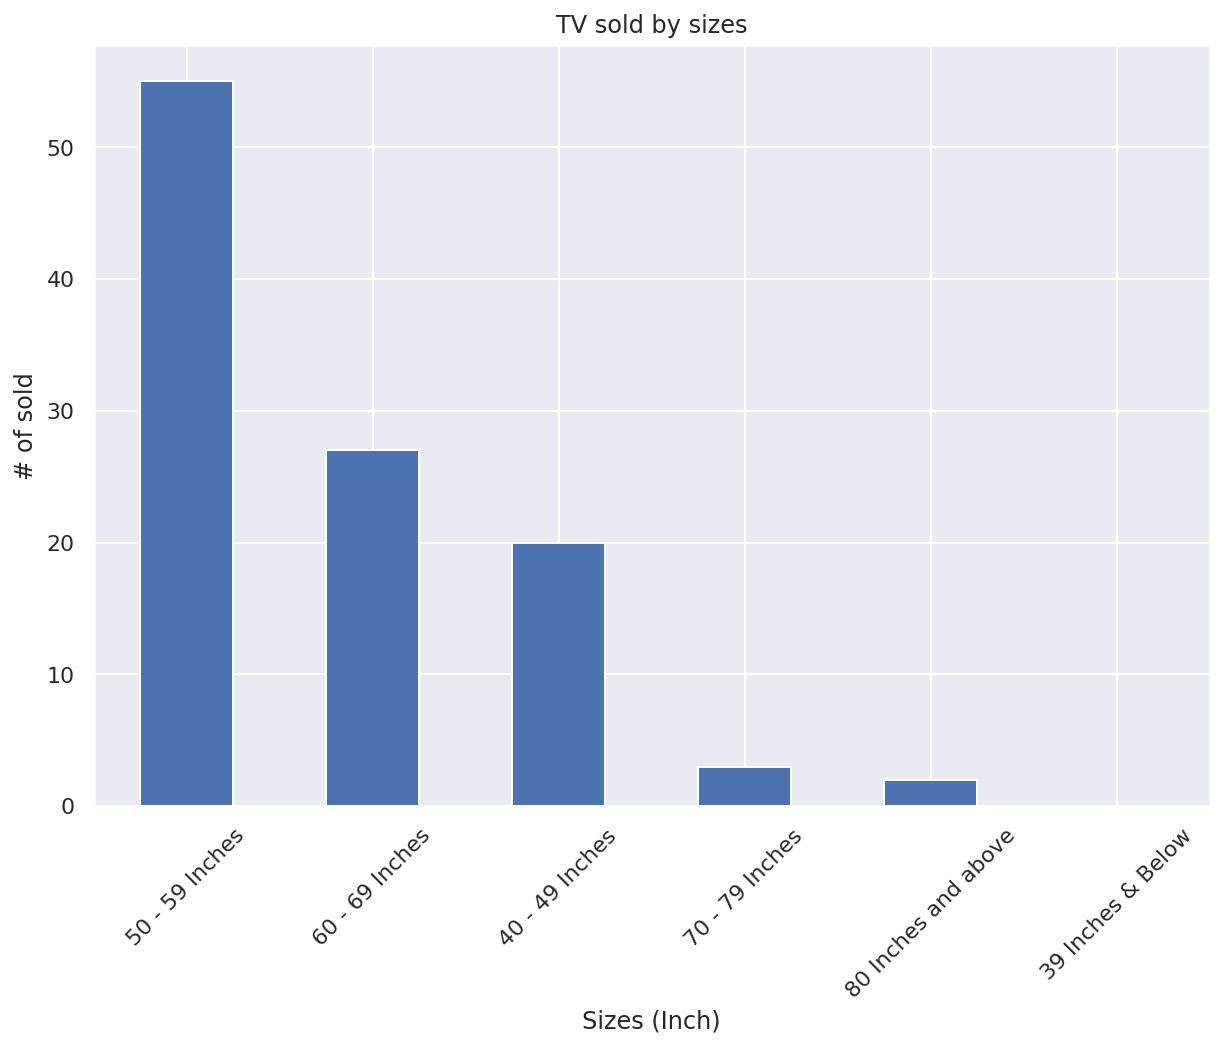

In [22]:
plt.figure(figsize=(10,7))
size_inch = final.groupby('Inch')['Qty_sold'].sum().sort_values(ascending=False).plot(kind='bar')
print(final.groupby('Inch')['Qty_sold'].sum().sort_values(ascending=False))
plt.title('TV sold by sizes')
plt.xlabel('Sizes (Inch)')
plt.ylabel('# of sold')
plt.xticks(rotation=45)

---
There are three category of TV popular size. Majority customer looking for sizes within 40 and 69 inches. There are less sales for size which are too big and no sales for size which are too small.

---

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '# of TV model')

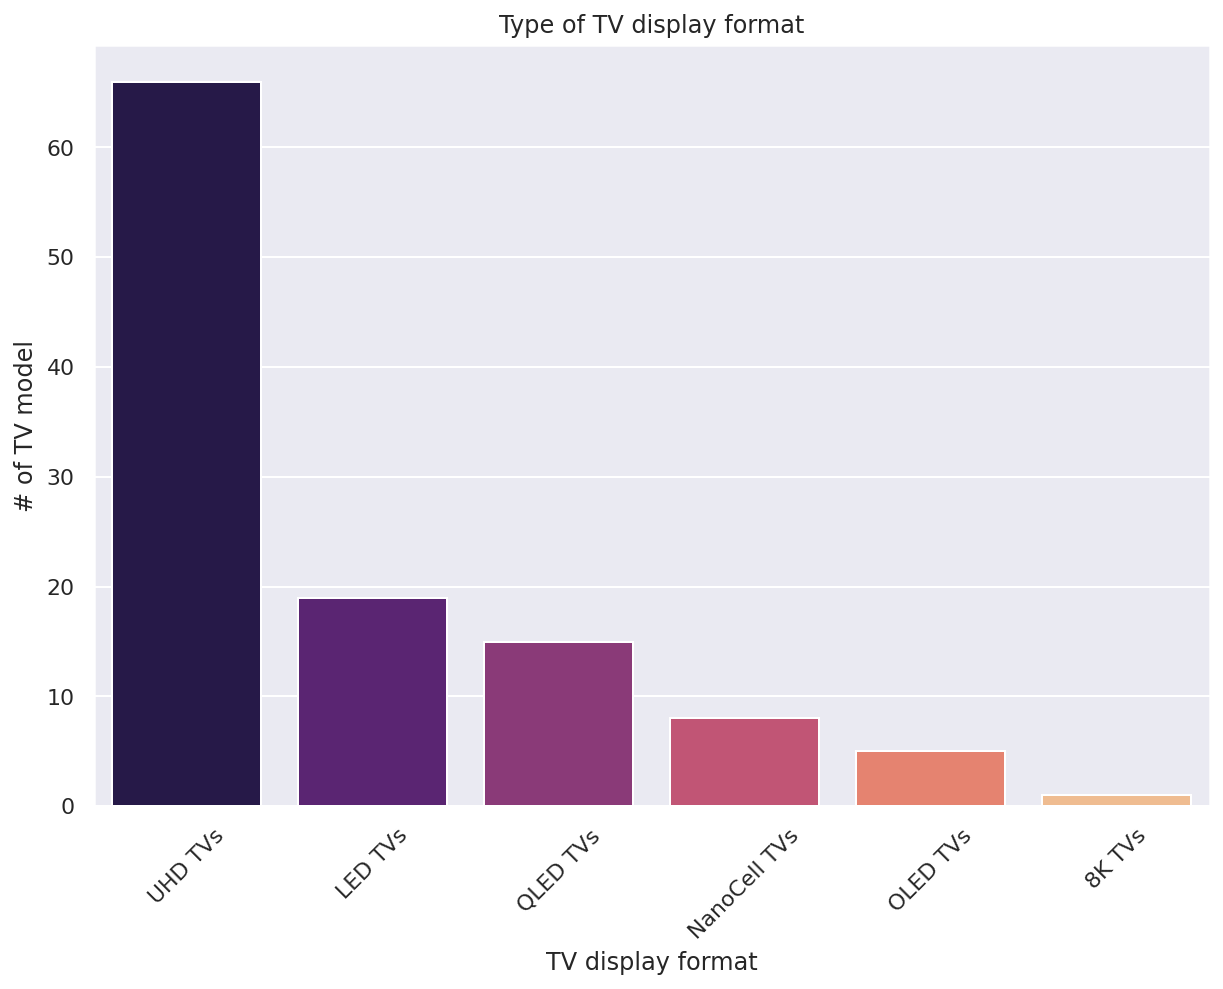

In [23]:
plt.figure(figsize=(10,7))
ax = sns.countplot(final['Display_format'], order =final['Display_format'].value_counts().index,palette = 'magma')
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=45)
plt.title('Type of TV display format')
plt.xlabel('TV display format')
plt.ylabel('# of TV model')

---
UHD TVs display format are the hottest product in this ecommerce shop. More than half of the TVs carried by this ecommerce shop are UHD TVs.

---

Display_format
UHD TVs         93
NanoCell TVs     8
QLED TVs         4
LED TVs          2
OLED TVs         0
8K TVs           0
Name: Qty_sold, dtype: int64


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

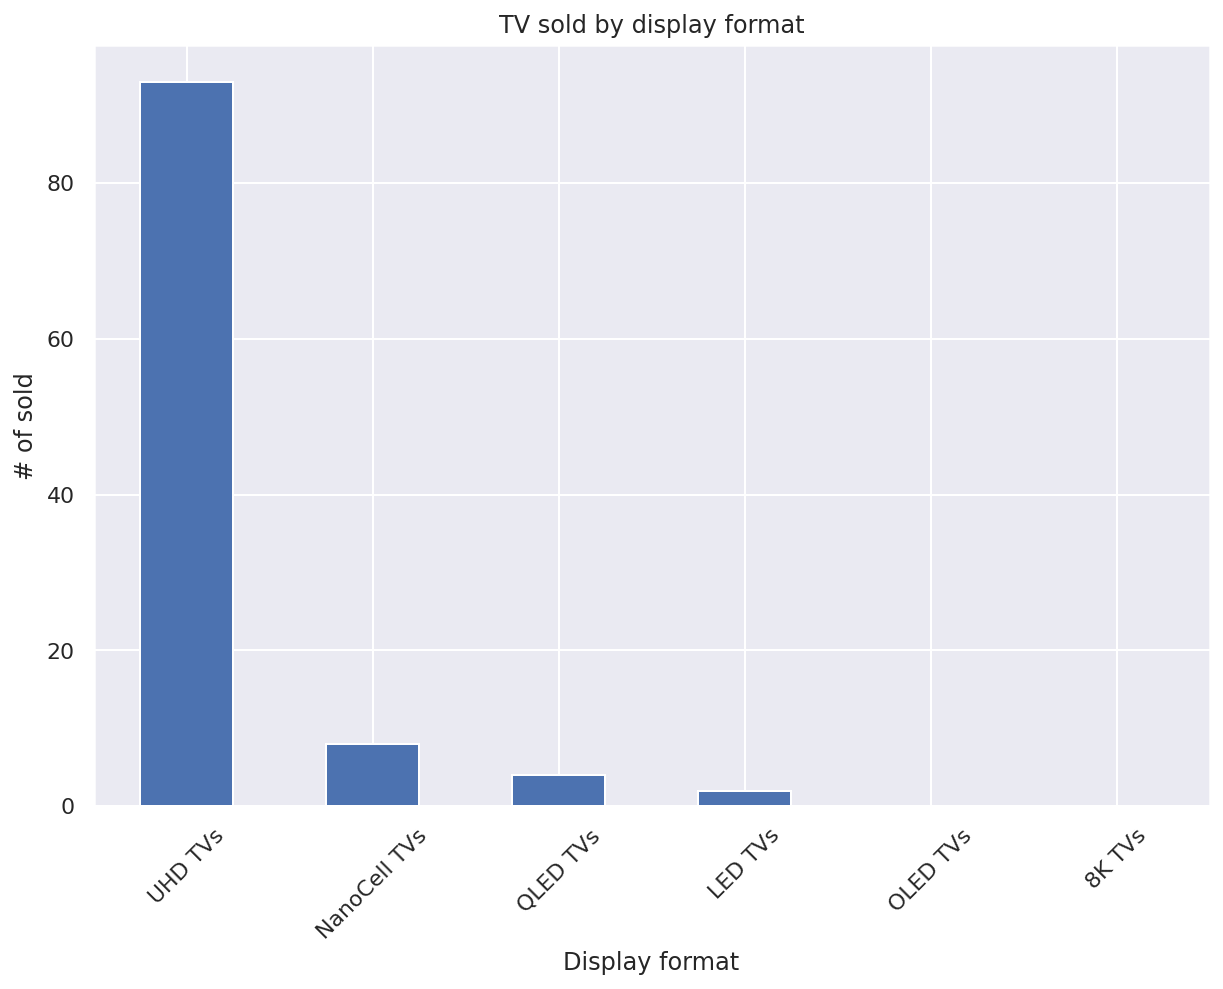

In [24]:
plt.figure(figsize=(10,7))
dis_for = final.groupby('Display_format')['Qty_sold'].sum().sort_values(ascending=False).plot(kind='bar')
print(final.groupby('Display_format')['Qty_sold'].sum().sort_values(ascending=False))
plt.title('TV sold by display format')
plt.xlabel('Display format')
plt.ylabel('# of sold')
plt.xticks(rotation=45)

---
UHD TVs display format are the technology currently accepted by most customer. 

---

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '# of TV model')

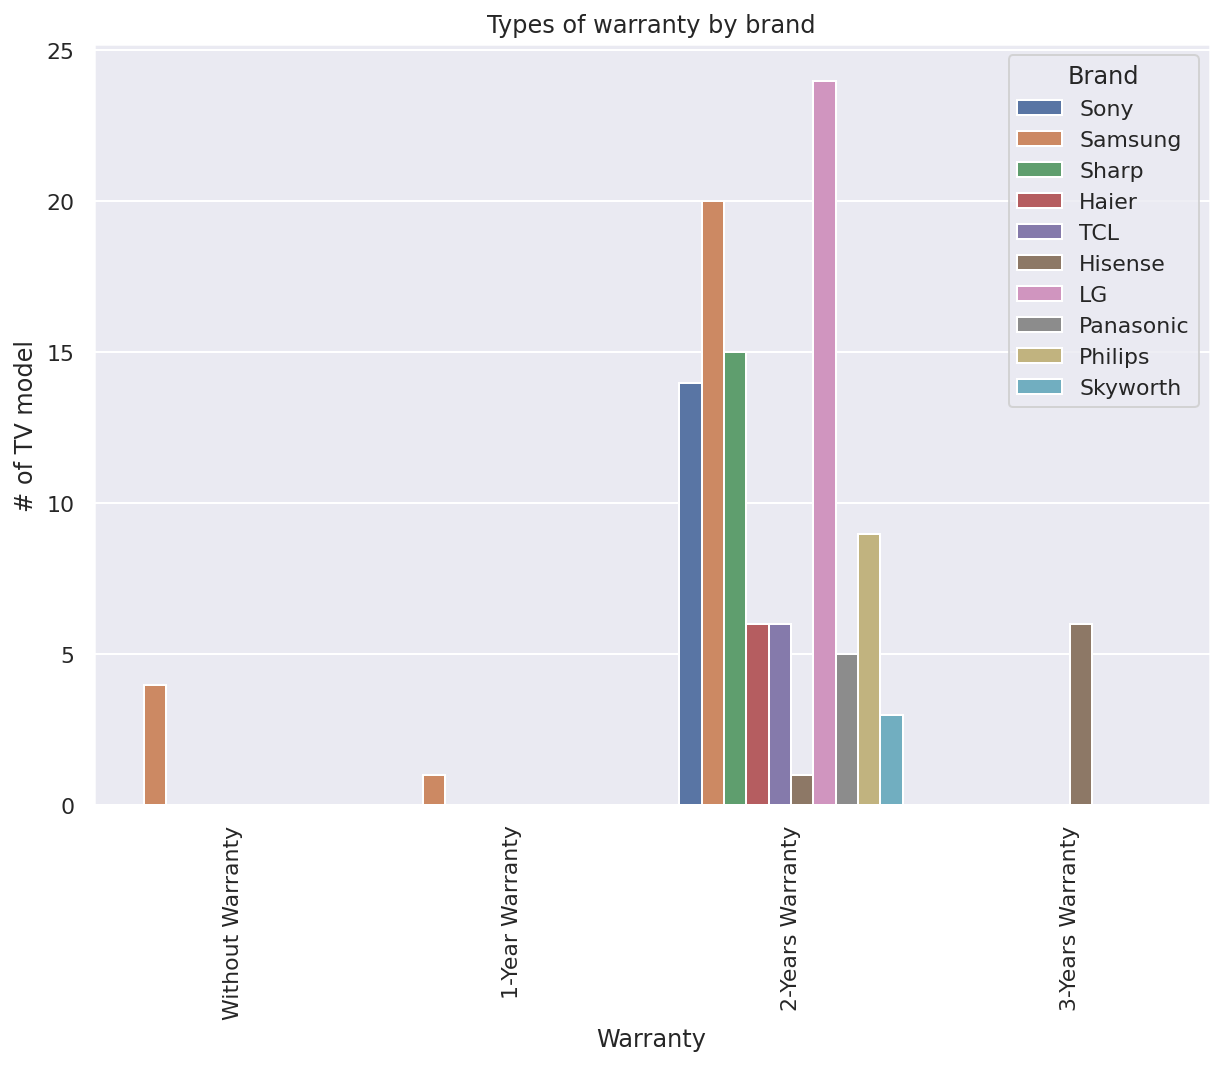

In [25]:
plt.figure(figsize=(10,7))
orders = ['Without Warranty','1-Year Warranty','2-Years Warranty','3-Years Warranty']
ax = sns.countplot(final['Warranty'], data=final, order =orders, hue=final['Brand'])
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)
plt.title('Types of warranty by brand')
plt.xlabel('Warranty')
plt.ylabel('# of TV model')

---
Majority brands offered 2 year of product warranty. Hisense brands offered up to 3 years of warranty.

---

In [26]:
#rating of each brand, No review mean there are no any purchase been made
rate = final[final['Rating'] != ''].groupby('Rating').agg({'Brand':'count'})
rate

,Brand
Rating,
1,1
4,2
4.3,1
4.5,2
4.8,2
5,32
No review,74


In [27]:
a = final.groupby('Brand')[['Revenue (RM)','Qty_sold']].sum()
print(a.sort_values(['Revenue (RM)'],ascending=False))
print('\n')
a.sum()

           Revenue (RM)  Qty_sold
Brand                            
LG               259708        59
Samsung          118784        42
Sony               5137         2
Sharp              2398         2
Philips            1699         1
Haier              1599         1
Hisense               0         0
Panasonic             0         0
Skyworth              0         0
TCL                   0         0




Revenue (RM)    389325
Qty_sold           107
dtype: int64

---
Majority of the buyers are giving 4 star and above which they are satisfy with the products and services. There are 107 unit of TVs being sold out which generate revenue RM389,325. LG and Samsung contribute high amount of revenue.

---

---
# **Conclusion**:

-There are 10 brands of TV carried by this ecommerce shop. LG and Samsung 
are the most popular brands, follow by Sony and Sharp. LG brands was the best selling which there were 59 unit sold out, while Samsung was the 2nd best selling which there were 42 unit sold.

-Those TV size of 39 inches & below as well as 80 inches & above are not hot selling TV. Customer are prefer size within 40 to 69 inches

-In current trend, people are more favor to UHD TVs where there are 93 units sold out.

-Most brands offer 2 years of warranty. There are some Samsung model offer 1 year of warranty while Hisense brands offer up to 3 years warranty.

-The ratings from customer mostly are above 4 star which they are satisfy with the product or services.

-Majority of the revenue are generated from LG and Samsung models. Total 107 unit of TVs being sold out which generate revenue RM389,325

-The trend of brand of model carried versus sold out are quite similiar, those with high number of models are the hot selling TVs. 


*   Advice to owner: Keep minimum stock level for not famous brand or sell out as soon as possible which may reduce the storage cost as well as fasten the company cash flow.
*   Advice to followers/competitors: Study the trend or pattern to strategies their business plan or set up price to stay competitive.


---

# **Additional (1): LG brands**

,Title,Stock,Link,Warranty,Display_format,Current_price (RM),Original_price (RM),Rating,Inch,Qty_sold,Brand,Revenue (RM)
138,LG UN74 Series 65” 4K Active HDR Smart UHD TV ...,Out of stock,https://www.senheng.com.my/lg-un74-65-inch-4k-...,2-Years Warranty,UHD TVs,4249,4549,4.8,60 - 69 Inches,4,LG,16996
149,LG NANO79 55 Inch 4K NanoCell TV with AI ThinQ...,Out of stock,https://www.senheng.com.my/lg-nano79-55-inch-4...,2-Years Warranty,NanoCell TVs,3888,4099,No review,50 - 59 Inches,0,LG,0


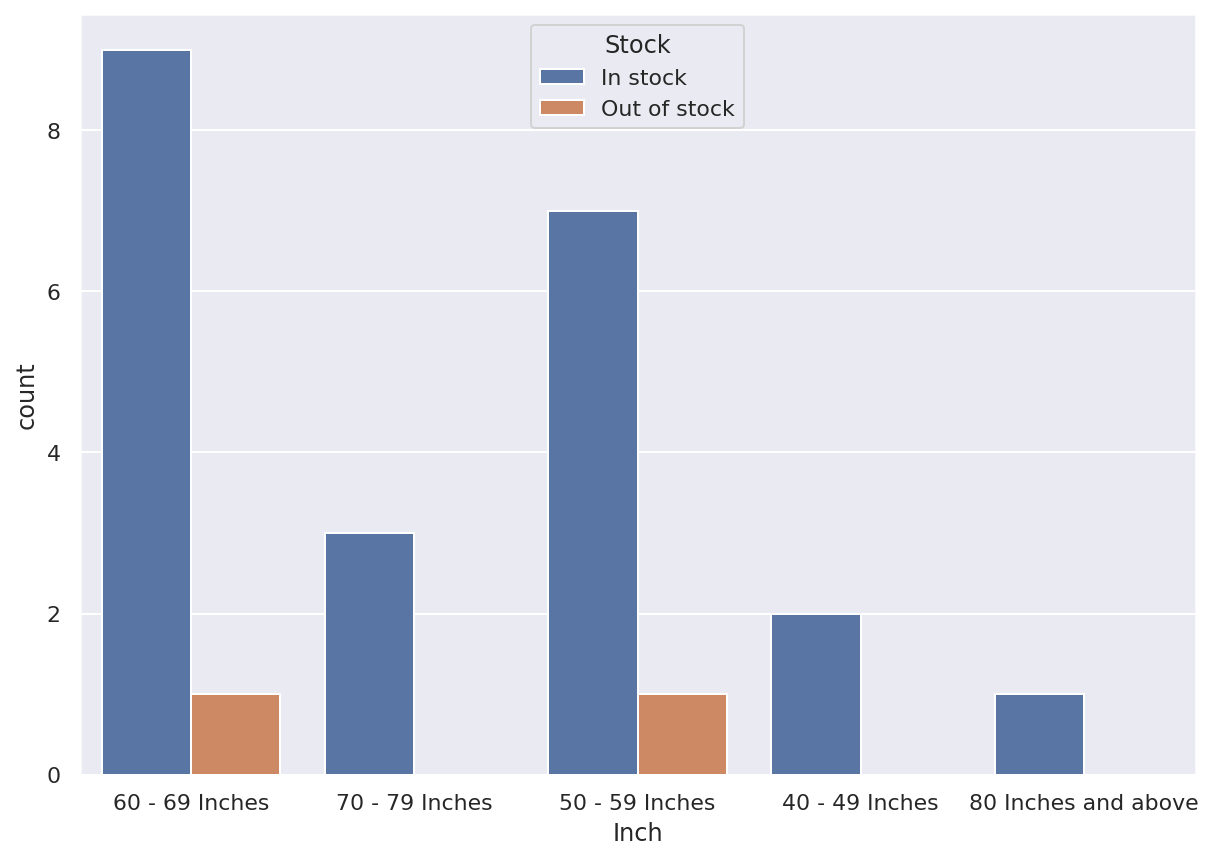

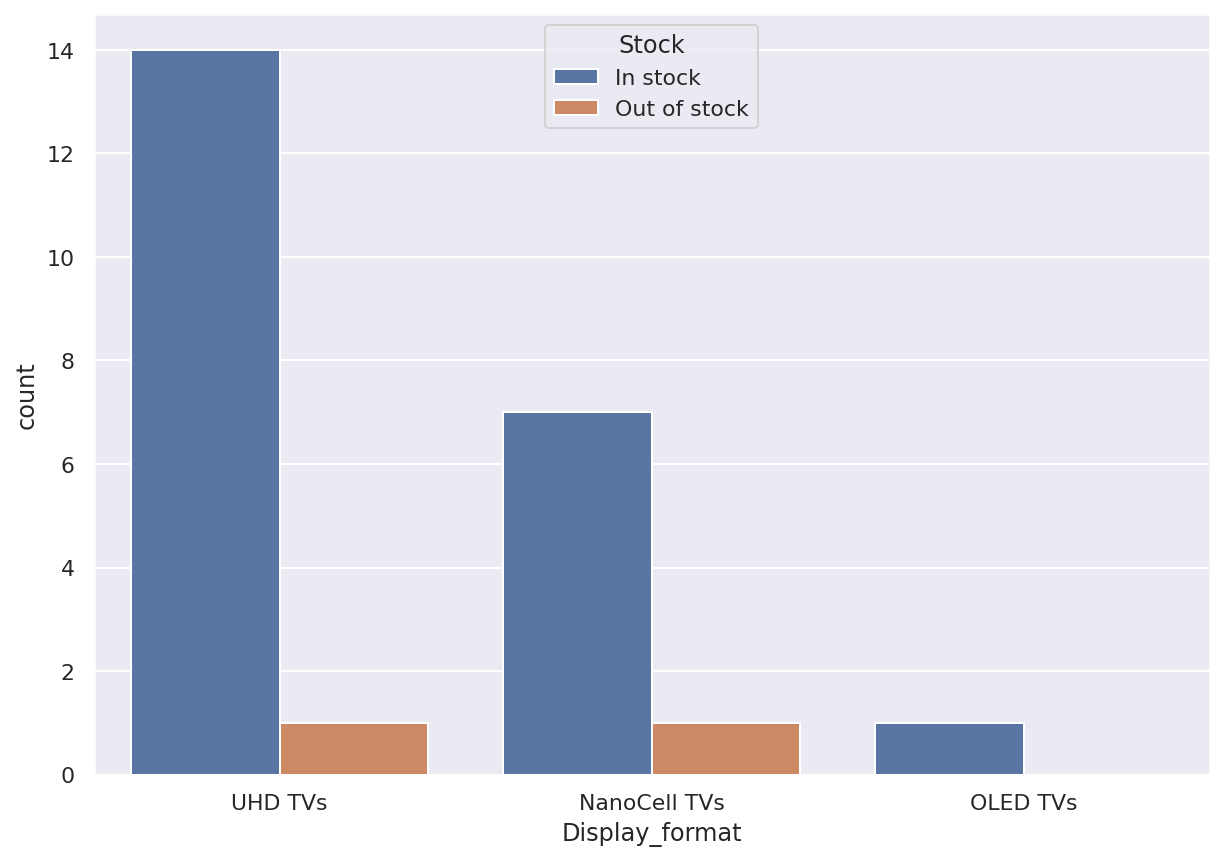

In [28]:
LG = final.loc[final['Brand']=='LG']
plt.figure(figsize=(10,7))
sns.countplot(x = 'Inch', data=LG, hue='Stock')

plt.figure(figsize=(10,7))
sns.countplot(x = 'Display_format', data=LG, hue='Stock')

LG.loc[LG['Stock']=='Out of stock']

---
As we look into detail of LG brands, we can see there are 9 models which are 60-69 inches. 7 models are 50-59 inches, 2 models are 40-49 inches, 3 models are 70-79 inches and only 1 model is 80 inches and above. From the graph, we can see that around half of the TVs display format are UHD. 

---

Display_format,NanoCell TVs,OLED TVs,UHD TVs
count,8.000000,1.0,15.000000
mean,6958.750000,8888.0,5826.800000
std,5310.766443,NaN,4721.172648
min,3099.000000,8888.0,1599.000000
25%,3971.250000,8888.0,2949.000000
50%,5543.500000,8888.0,3599.000000
75%,6799.000000,8888.0,7482.500000
max,19599.000000,8888.0,17999.000000


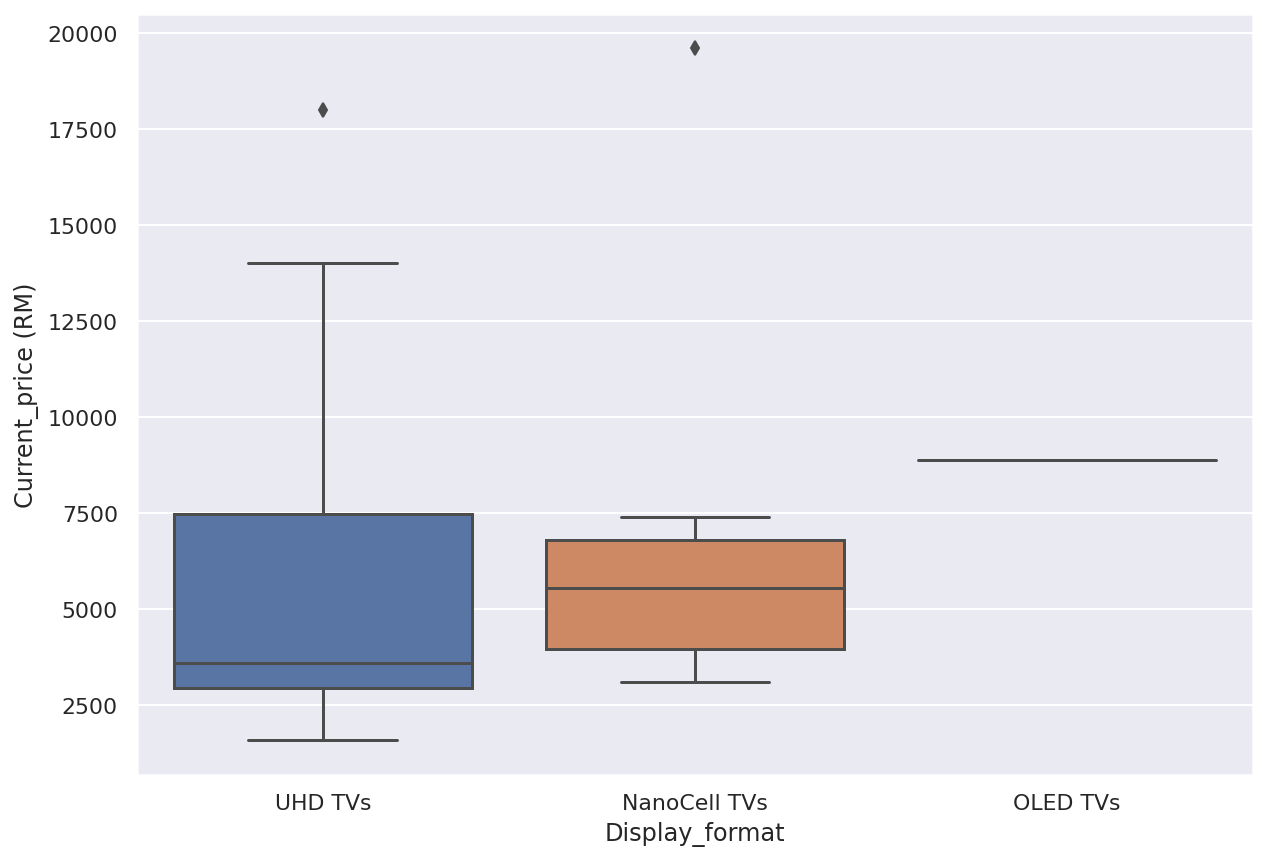

In [29]:
plt.figure(figsize=(10,7))
sns.boxplot(data=LG,x='Display_format',y='Current_price (RM)')

LG.groupby('Display_format')['Current_price (RM)'].describe().transpose()

---
The price of UHD TVs is affordable, 50% and above of the LG UHD TVs are around RM3600. However, the price of Nanocell TVs is around double higher than UHD TVs. 

---

# **Additional (2): Samsung brands**

,Title,Stock,Link,Warranty,Display_format,Current_price (RM),Original_price (RM),Rating,Inch,Qty_sold,Brand,Revenue (RM)
150,Samsung TU8000 Crystal UHD 4K Smart TV (2020),Out of stock,https://www.senheng.com.my/samsung-55-inch-tu8...,2-Years Warranty,UHD TVs,2719,2999,5,50 - 59 Inches,7,Samsung,19033


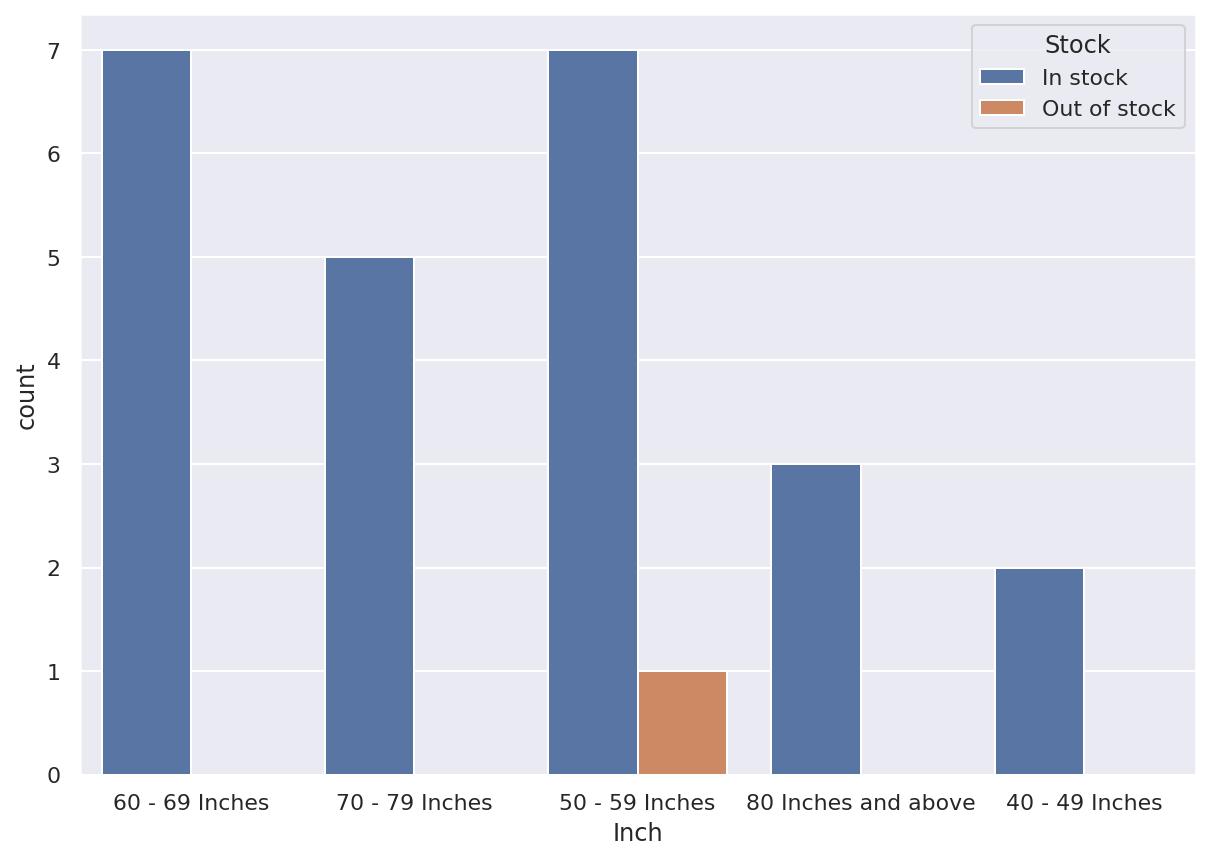

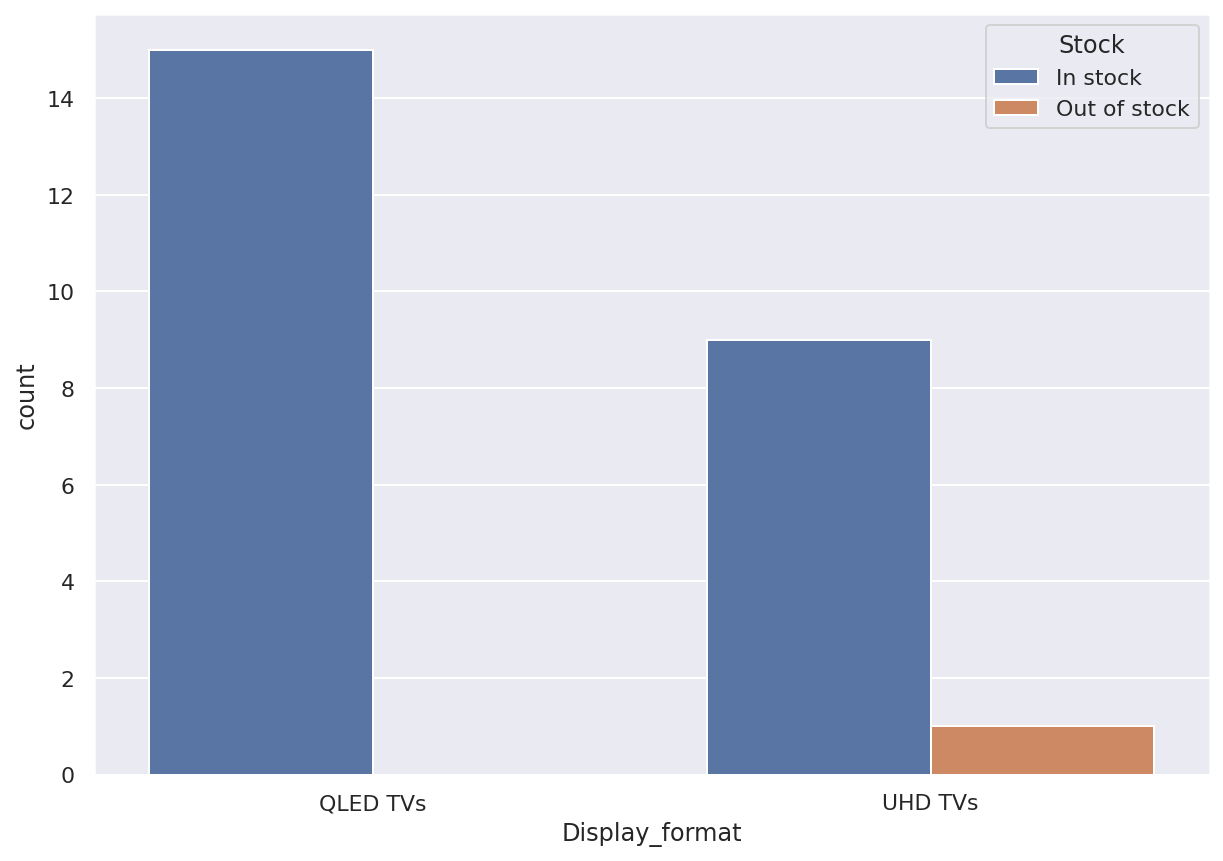

In [30]:
SS = final.loc[final['Brand']=='Samsung']
plt.figure(figsize=(10,7))
sns.countplot(x = 'Inch', data=SS, hue='Stock')

plt.figure(figsize=(10,7))
sns.countplot(x = 'Display_format', data=SS, hue='Stock')

SS.loc[SS['Stock']=='Out of stock']

---
As we look into detail of Samsung brands, we can see there are 7 models which are 60-69 inches. 5 models are 70-79 inches, 7 models are 50-59 inches, 2 models are 40-49 inches and only 3 model is 80 inches and above. From the graph, we can see that around near to half of TVs display format are QLED. 

---

Display_format,QLED TVs,UHD TVs
count,15.000000,10.000000
mean,9008.266667,4222.700000
std,4864.430175,2658.704198
min,3149.000000,1666.000000
25%,5399.000000,2516.500000
50%,8299.000000,3274.000000
75%,11343.500000,4586.500000
max,19999.000000,9999.000000


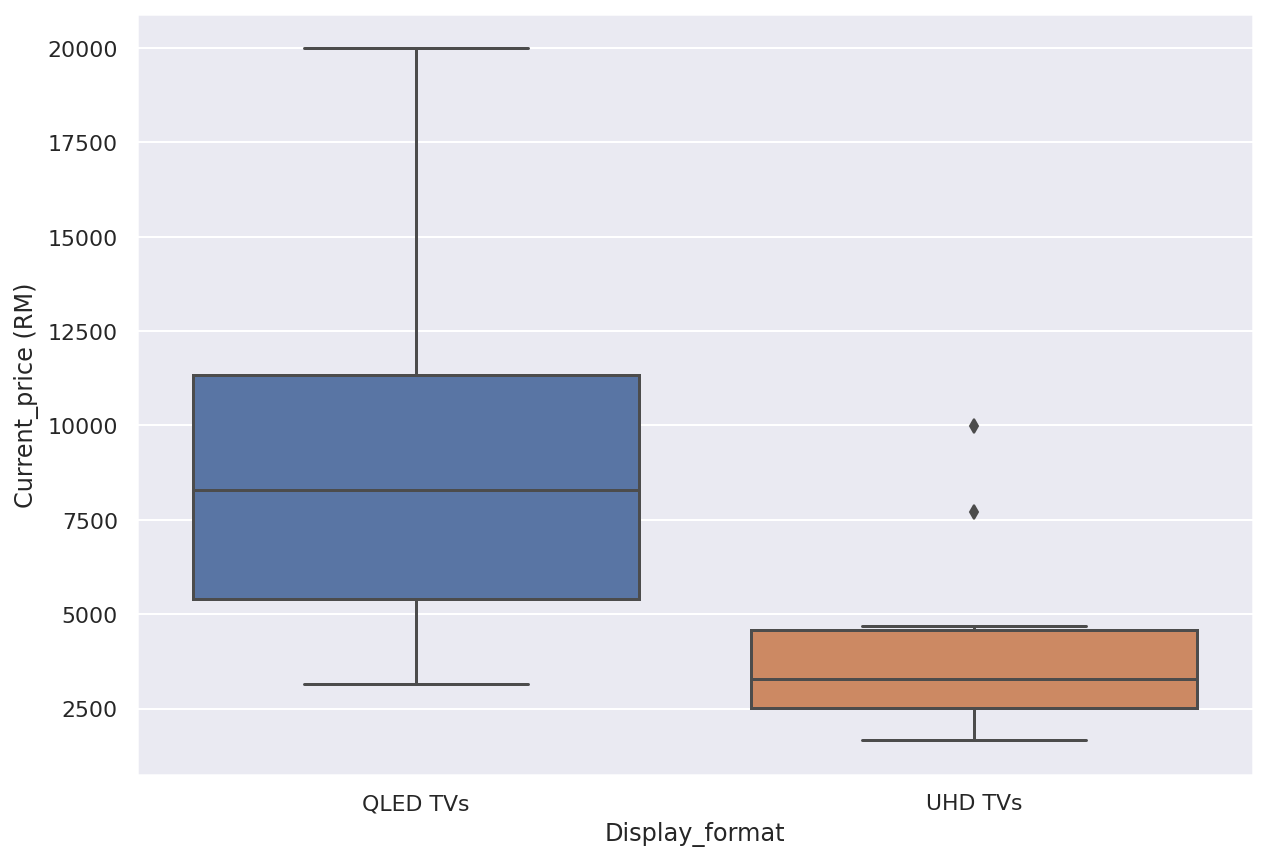

In [31]:
plt.figure(figsize=(10,7))
sns.boxplot(data=SS,x='Display_format',y='Current_price (RM)')

SS.groupby('Display_format')['Current_price (RM)'].describe().transpose()

---
The price of UHD TVs is affordable, 50% and above of the LG UHD TVs are around RM3300. However, the price of QLED TVs is RM8300 much more higher than UHD TVs. 

---

# **Additional (3): Sony brands**

,Title,Stock,Link,Warranty,Display_format,Current_price (RM),Original_price (RM),Rating,Inch,Qty_sold,Brand,Revenue (RM)
125,Sony X8000H Series Smart TV (Android TV) KD-55...,Out of stock,https://www.senheng.com.my/sony-x8000h-series-...,2-Years Warranty,UHD TVs,3249,3499,4,50 - 59 Inches,1,Sony,3249
126,Sony 49 Inch X80H 4K Ultra HD High Dynamic Ran...,Out of stock,https://www.senheng.com.my/sony-49-inch-x80h-4...,2-Years Warranty,UHD TVs,2899,3099,5,40 - 49 Inches,0,Sony,0
131,Sony 65 Inch X90H Full Array LED 4K Ultra HD H...,Out of stock,https://www.senheng.com.my/sony-65-inch-x90h-f...,2-Years Warranty,UHD TVs,6499,6999,No review,60 - 69 Inches,0,Sony,0
134,Sony 43 Inch X75H 4K Ultra HD HDR Smart TV SNY...,Out of stock,https://www.senheng.com.my/sony-43-inch-x75h-4...,2-Years Warranty,UHD TVs,1888,2199,5,40 - 49 Inches,1,Sony,1888
140,Sony 65 Inch X80H 4K Ultra HD High Dynamic Ran...,Out of stock,https://www.senheng.com.my/sony-65-inch-x80h-4...,2-Years Warranty,UHD TVs,4259,4599,5,60 - 69 Inches,0,Sony,0
151,Sony 55 Inch X90H Full Array LED 4K Ultra HD H...,Out of stock,https://www.senheng.com.my/sony-55-inch-x90h-f...,2-Years Warranty,UHD TVs,3999,4299,No review,50 - 59 Inches,0,Sony,0


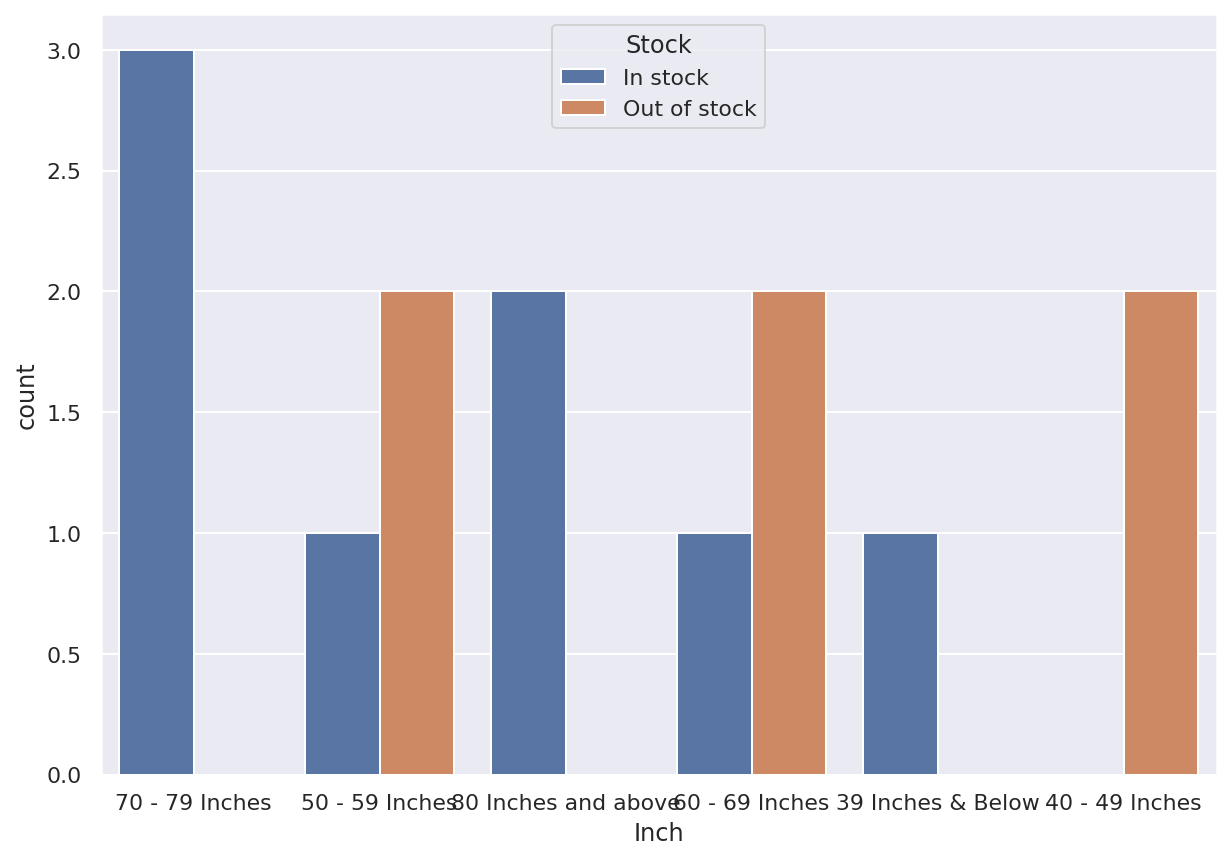

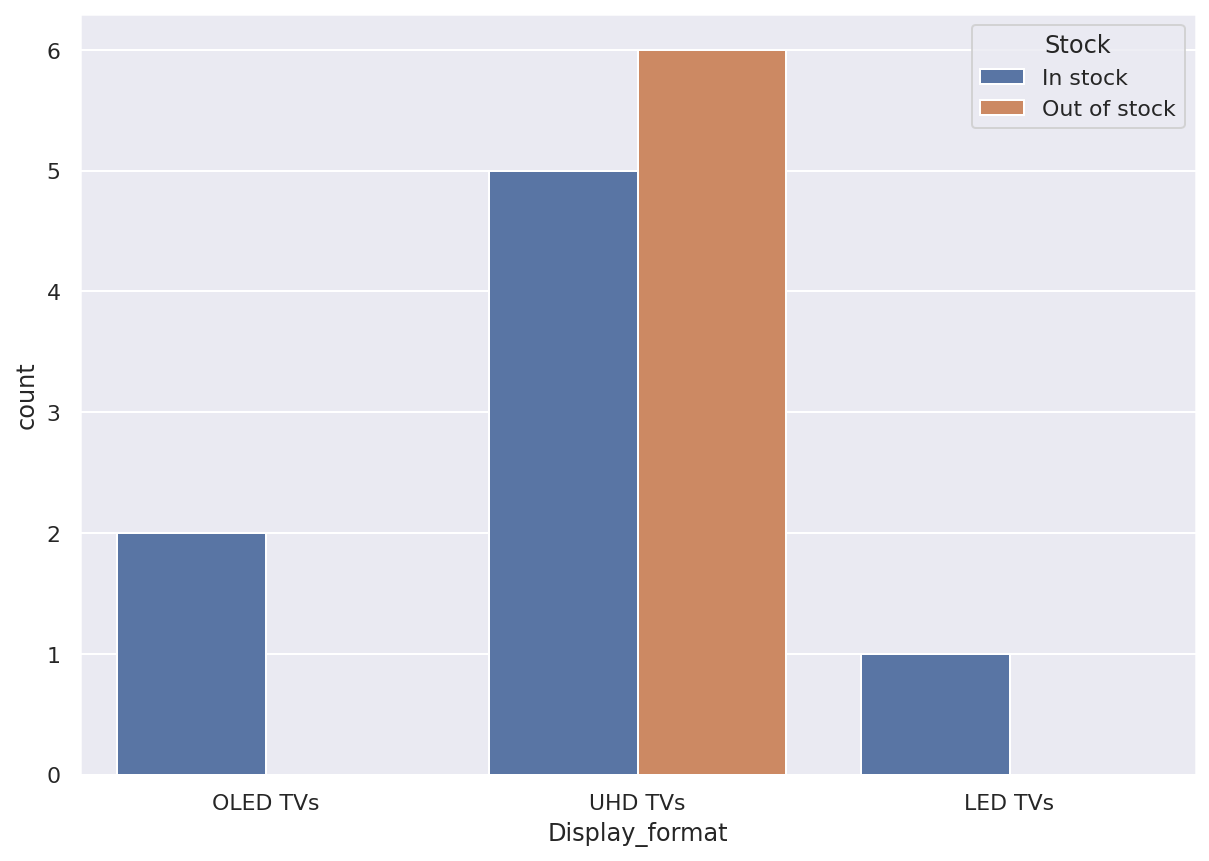

In [32]:
SN = final.loc[final['Brand']=='Sony']
plt.figure(figsize=(10,7))
sns.countplot(x = 'Inch', data=SN, hue='Stock')

plt.figure(figsize=(10,7))
sns.countplot(x = 'Display_format', data=SN, hue='Stock')

SN.loc[SN['Stock']=='Out of stock']

---
As we look into detail of Sony brands, we can see there are not much stock of Sony brands. Currently only have 3 models for size 70-79 inches, other are equal or less than 2 models. There are lots of model out of stock.

---

Display_format,LED TVs,OLED TVs,UHD TVs
count,1.0,2.000000,11.000000
mean,989.0,17199.000000,11997.909091
std,NaN,5374.011537,21211.056855
min,989.0,13399.000000,1888.000000
25%,989.0,15299.000000,3074.000000
50%,989.0,17199.000000,4259.000000
75%,989.0,19099.000000,8799.000000
max,989.0,20999.000000,74999.000000


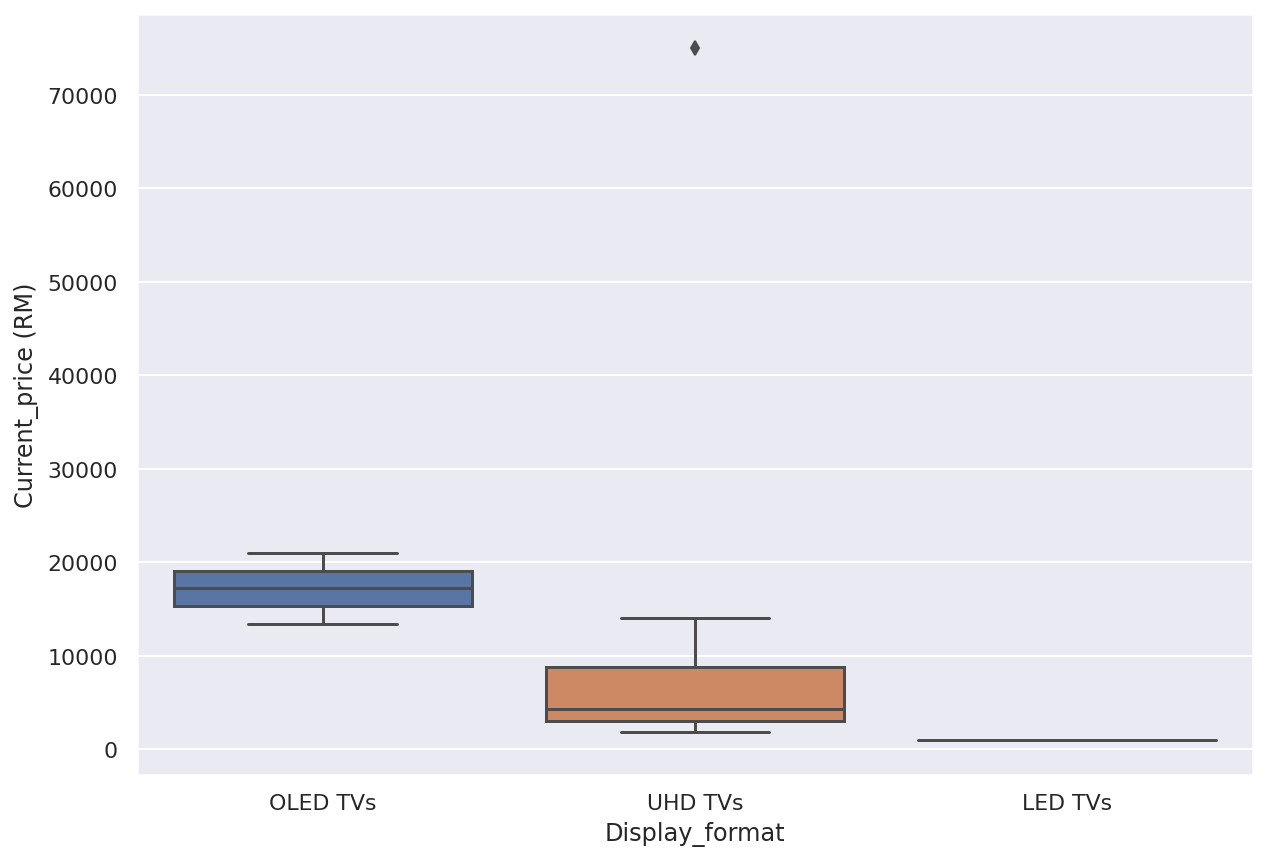

In [33]:
plt.figure(figsize=(10,7))
sns.boxplot(data=SN,x='Display_format',y='Current_price (RM)')

SN.groupby('Display_format')['Current_price (RM)'].describe().transpose()

---
50% and above of the Sony UHD TVs are around RM3550. There is one model of LED TVs which the price is within RM1000.

---

# **Additional (4): Sharp brands**

,Title,Stock,Link,Warranty,Display_format,Current_price (RM),Original_price (RM),Rating,Inch,Qty_sold,Brand,Revenue (RM)
132,Sharp 50-Inch Full HD TV 2TC50BG1X,Out of stock,https://www.senheng.com.my/sharp-50-inch-full-...,2-Years Warranty,LED TVs,1899,3099,No review,50 - 59 Inches,0,Sharp,0
139,Sharp 32-Inch HD Ready TV 2TC32BG1X,Out of stock,https://www.senheng.com.my/sharp-32-inch-hd-re...,2-Years Warranty,LED TVs,999,1199,No review,39 Inches & Below,0,Sharp,0
121,Sharp 50-Inch 4K UHD TV 4TC50BK1X,Out of stock,https://www.senheng.com.my/sharp-50-inch-4k-uh...,2-Years Warranty,UHD TVs,2149,3599,No review,50 - 59 Inches,0,Sharp,0


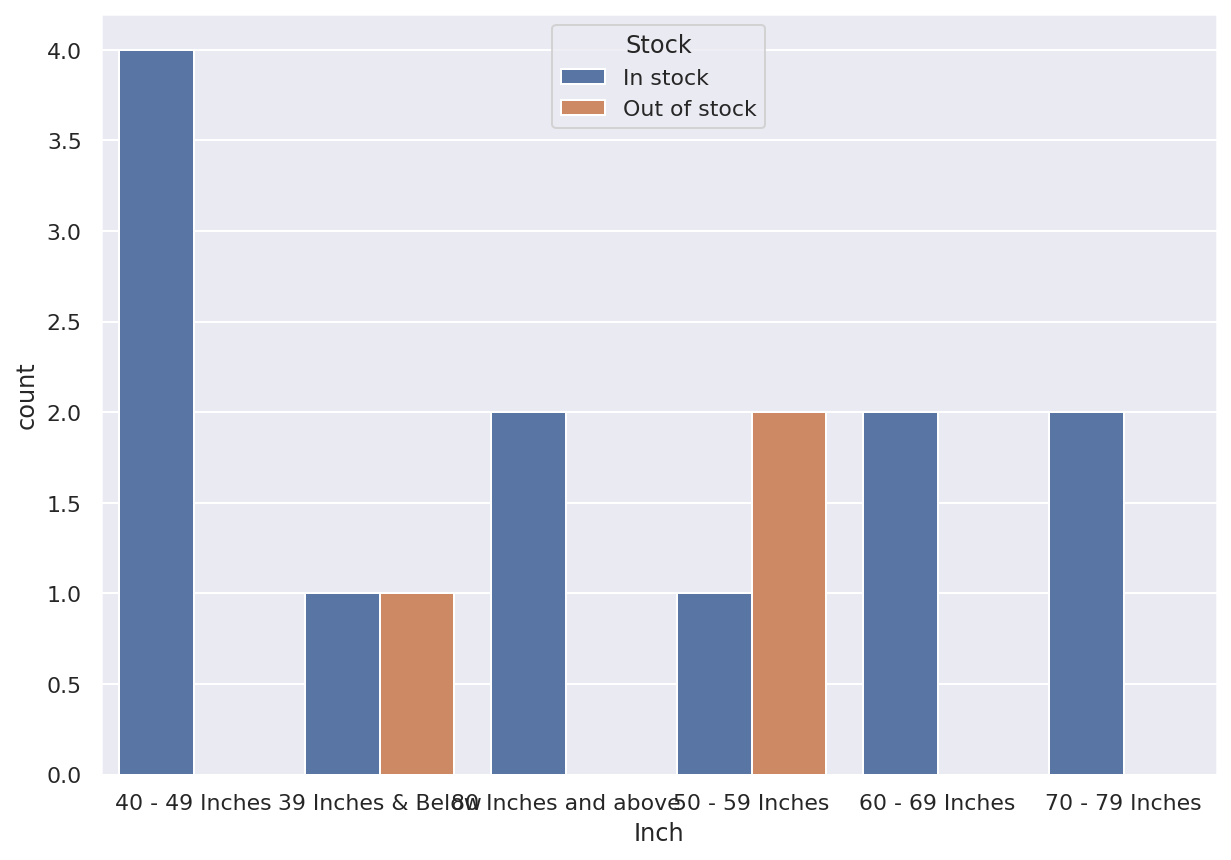

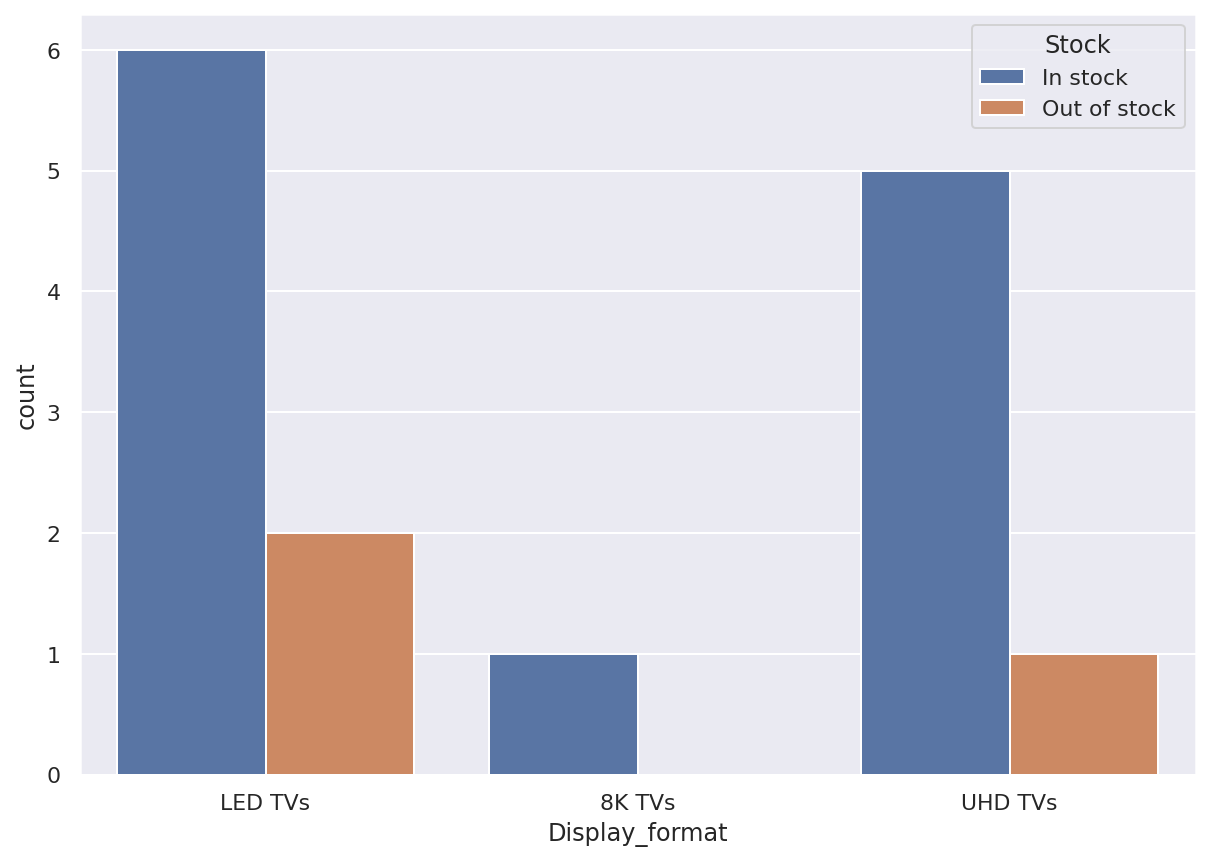

In [34]:
SP = final.loc[final['Brand']=='Sharp']
plt.figure(figsize=(10,7))
sns.countplot(x = 'Inch', data=SP, hue='Stock')

plt.figure(figsize=(10,7))
sns.countplot(x = 'Display_format', data=SP, hue='Stock')

SP.loc[SP['Stock']=='Out of stock']

---
As we look into detail of Sharp brands, there are 4 models of size 40-49 inches and other sizes are either 2 models or less. Majority Sharp model are LED TVs, 2nd are UHD TVs and only 1 model of 8K TVs.

---

Display_format,8K TVs,LED TVs,UHD TVs
count,1.0,8.000000,6.000000
mean,68888.0,1309.000000,5388.833333
std,NaN,398.138526,4872.169965
min,68888.0,779.000000,2149.000000
25%,68888.0,999.000000,2515.750000
50%,68888.0,1249.000000,3699.000000
75%,68888.0,1574.000000,5174.000000
max,68888.0,1899.000000,14999.000000


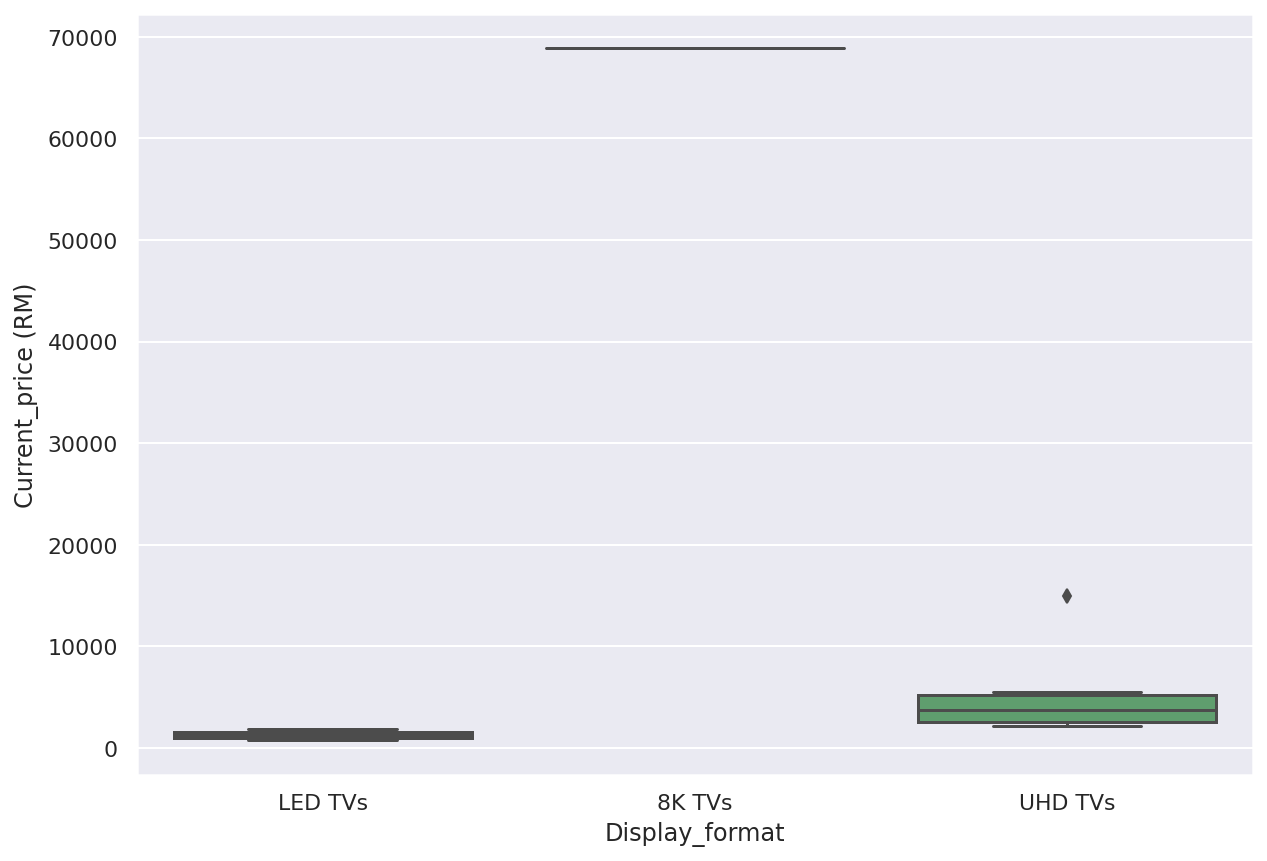

In [35]:
plt.figure(figsize=(10,7))
sns.boxplot(data=SP,x='Display_format',y='Current_price (RM)')

SP.groupby('Display_format')['Current_price (RM)'].describe().transpose()

---
50% and above of the Sharp UHD TVs are around RM3700. While 50% and above of the Sharp LED TVs are around RM1300.

---

---
# **Conclusion (LG, Samsung, Sony, Sharp)**:

-LG brands mostly are UHD TVs(focus) and NanoCell TVs, and mojority size are 60-69 inches. 50% of the price of UHD TVs around RM3600 while the price of NanoCell TVs is double up of UHD TVs.


-Samsung brands mostly are UHD TVs and QLED TVs(focus), and majority size are 50-59 inches and 60-69 inches. 50% of the price of UHD TVs around RM3300 while the price of QLED TVs is double up of UHD TVs.


-Sony brands mostly are UHD TVs(focus) and OLED TVs, but lots of sizes are out of stock. 50% of the price of UHD TVs around RM3550 while 50% of OLED TVs more RM17000.

-Sharp brands mostly are UHD TVs and LED TVs(focus), and majority size are 40-49 inches. 50% of the price around RM3700 while 50% of LED TVs within around RM 1300.

-Majority of famous brand do manufacture UHD TVs which so call current standard, the price are around RM3600 and there are not much price different between brands. 

-Samsung more focus on QLED TVs which is using more advance technoloy and the price are expensive, while Sharp do focus on LED TVs where the price might affordable for low income group.

-Each brands having different popular of size of TVs screen. However, very few TV sets in the ecommerce site are too big or too small.


---